<a href="https://colab.research.google.com/github/KyleRoss-rice/SignIconicityPredictor/blob/main/models/classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries


In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import sklearn 

from google.colab import files
from sklearn import kernel_ridge
from sklearn import ensemble
from sklearn import tree
from sklearn import preprocessing 
from sklearn import feature_extraction
from sklearn.model_selection import RandomizedSearchCV
from sklearn import decomposition
from sklearn import pipeline
from sklearn.metrics import mean_absolute_error
from sklearn import neural_network
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
import scipy.stats as stats
from itertools import cycle
from scipy import interp
state = 0
from sklearn.utils.fixes import loguniform
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import torch
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn import manifold

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Fetch Regression Data

In [ ]:
!wget -c https://raw.githubusercontent.com/KyleRoss-rice/SignIconicityPredictor/main/data/classification_data/classification_X_train.csv
!wget -c https://raw.githubusercontent.com/KyleRoss-rice/SignIconicityPredictor/main/data/classification_data/classification_X_test.csv
!wget -c https://raw.githubusercontent.com/KyleRoss-rice/SignIconicityPredictor/main/data/classification_data/classification_y_train.csv
!wget -c https://raw.githubusercontent.com/KyleRoss-rice/SignIconicityPredictor/main/data/classification_data/classification_y_test.csv

--2020-12-01 18:08:27--  https://raw.githubusercontent.com/KyleRoss-rice/SignIconicityPredictor/main/data/classification_data/classification_X_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702195 (686K) [text/plain]
Saving to: ‘classification_X_train.csv’

classification_X_tr 100%[===================>] 685.74K  --.-KB/s    in 0.06s   

2020-12-01 18:08:28 (11.7 MB/s) - ‘classification_X_train.csv’ saved [702195/702195]

--2020-12-01 18:08:28--  https://raw.githubusercontent.com/KyleRoss-rice/SignIconicityPredictor/main/data/classification_data/classification_X_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com

## Create DataFrames

In [ ]:
X_train = pd.read_csv("classification_X_train.csv")
X_test = pd.read_csv("classification_X_test.csv")

y_train = np.array(pd.read_csv("classification_y_train.csv")).reshape(-1).astype('int32')
y_test = np.array(pd.read_csv("classification_y_test.csv")).reshape(-1).astype('int32')

X_train_ID = X_train["ASL-Lex 2.0 ID"]    # saving IDs for plots
X_test_ID = X_test["ASL-Lex 2.0 ID"]      # saving IDs for plots

X=X_train.append(X_test)                  # compiling all signs for visualizing with TSNE
y=np.hstack([y_train,y_test])             # compiling all signs for visualizing with TSNE

### Remove Sign IDs in the first column

In [ ]:
#Remove sign IDs in the first column
X_train_ID = X_train.columns[0]
X_test_ID = X_test.columns[0]
X_train.drop(X_train.columns[0], axis=1, inplace=True)    # Dropping the ID field since it will not be included in the training 
X_test.drop(X_test.columns[0], axis=1, inplace=True)

### Summarizing the Dataset 

In [ ]:
from collections import Counter
target = pd.DataFrame(y).values[:,-1]
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))


Class=4, Count=691, Percentage=27.640%
Class=1, Count=96, Percentage=3.840%
Class=0, Count=1443, Percentage=57.720%
Class=3, Count=125, Percentage=5.000%
Class=2, Count=145, Percentage=5.800%


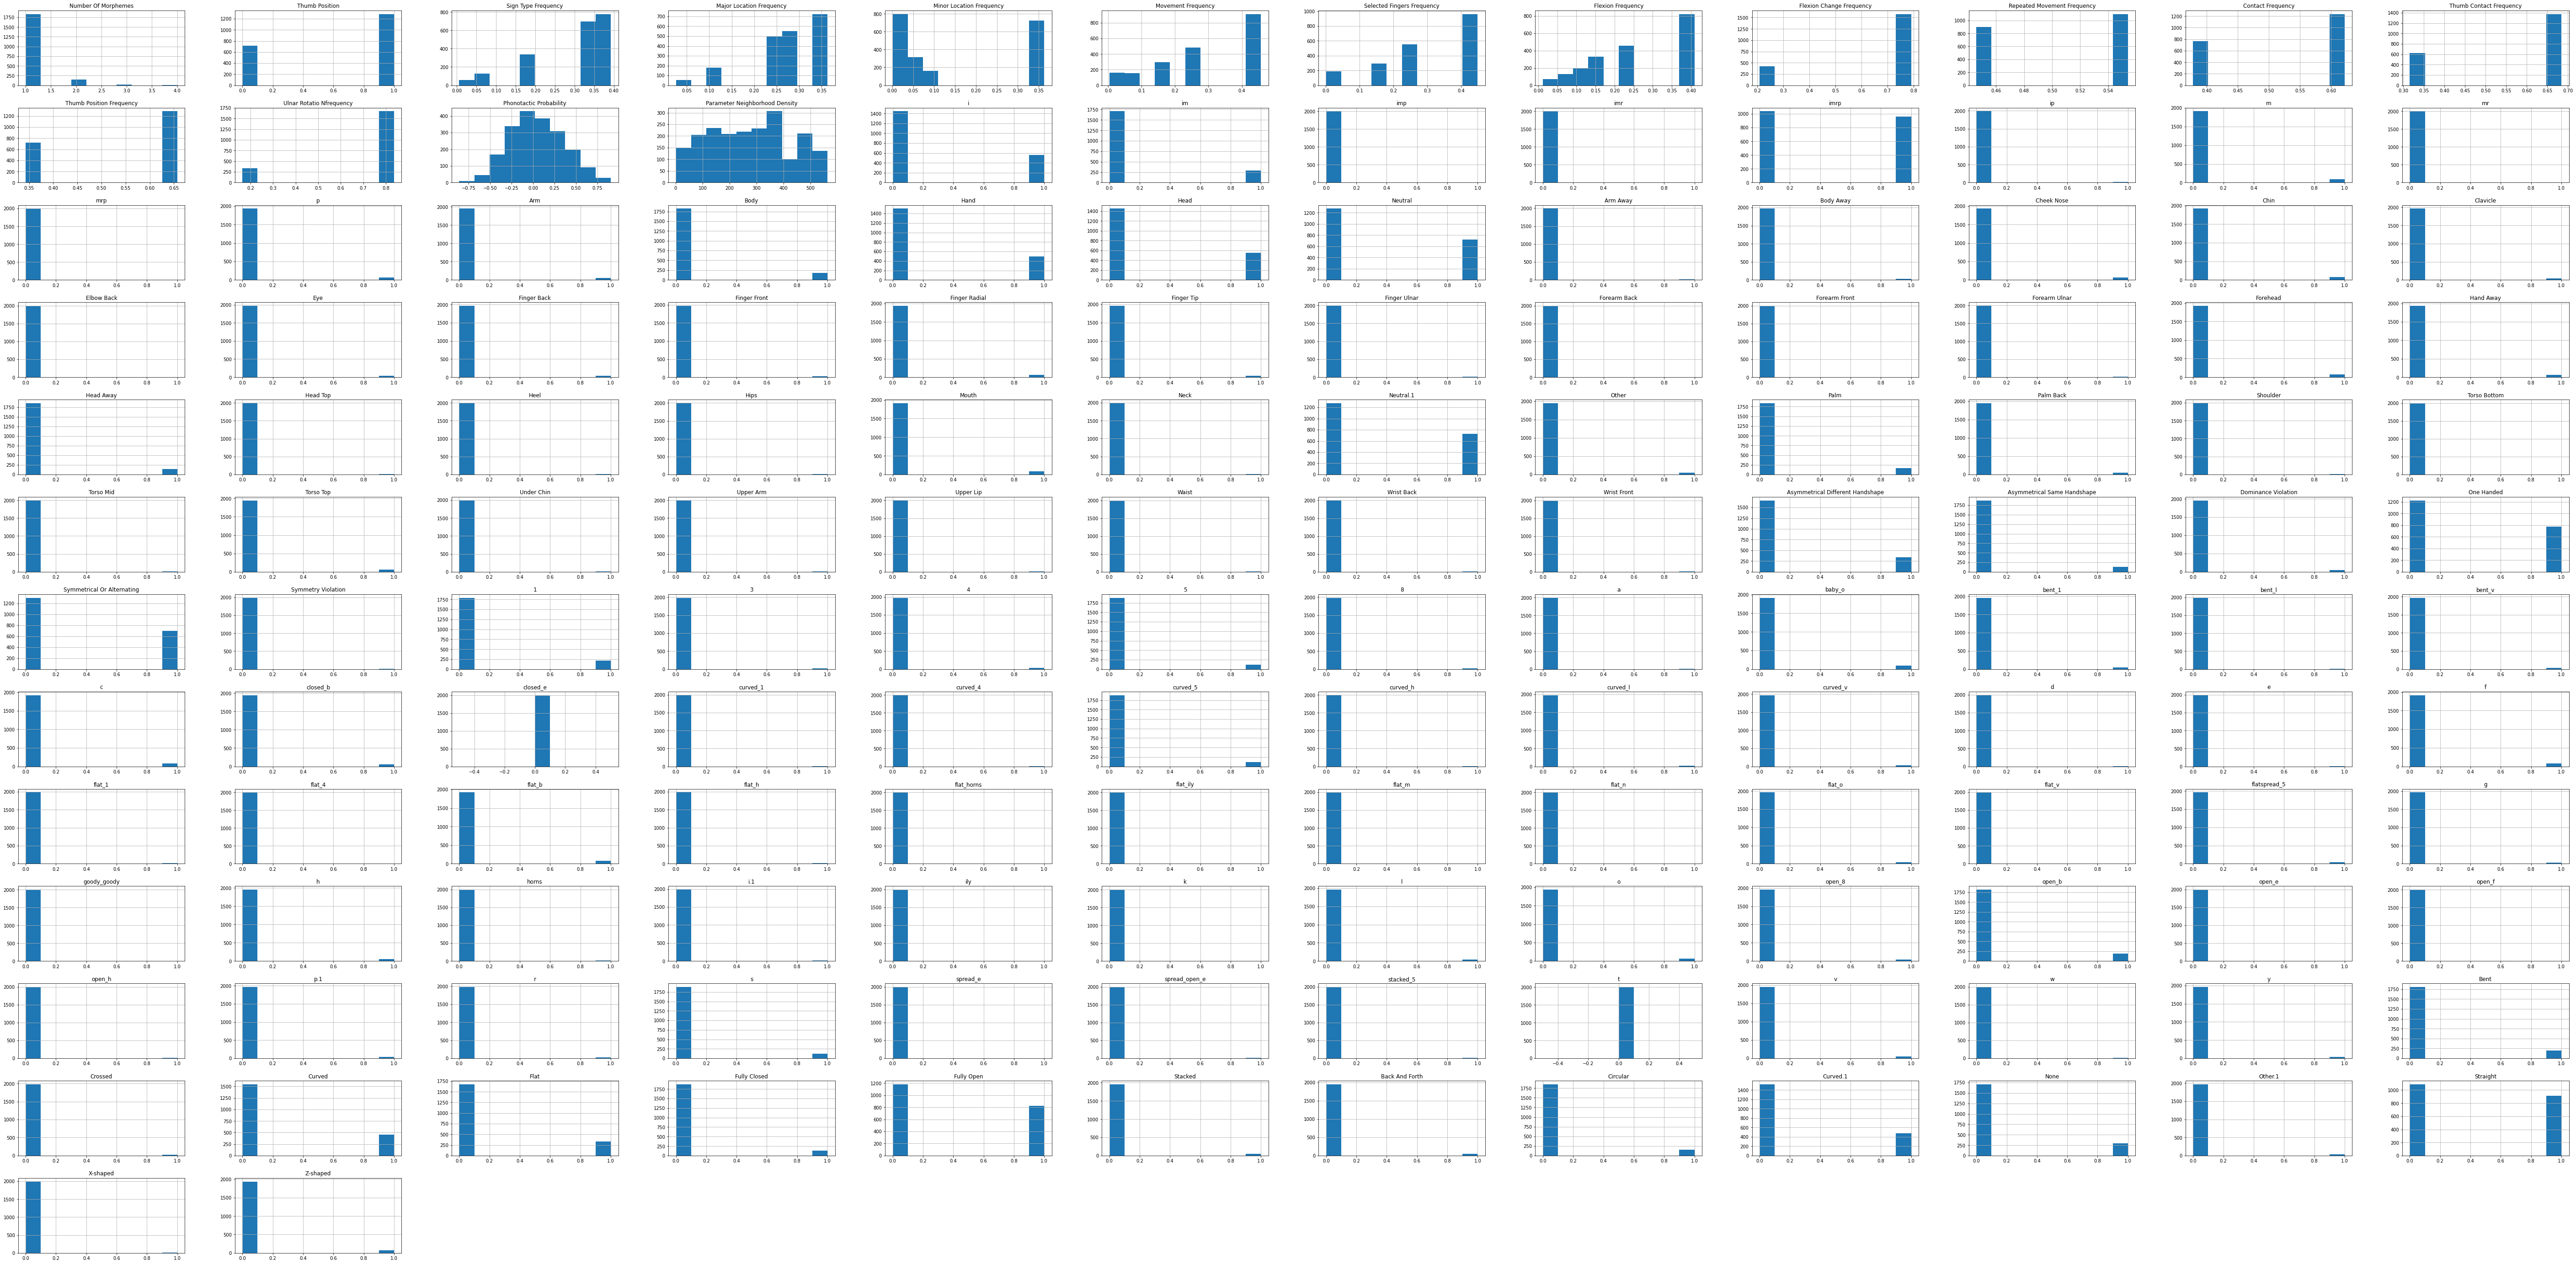

In [ ]:

X_train.hist(figsize=(100,50))
plt.show()

<Figure size 432x288 with 0 Axes>

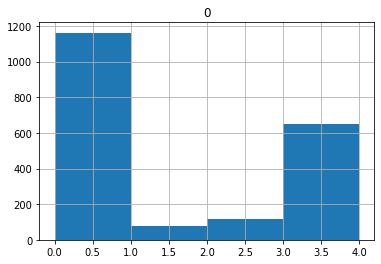

In [ ]:
plt.figure()
plt.xticks=['arbitrary','both','pantomimic','perceptual']
pd.DataFrame(y_train).hist(bins=4)
plt.show()

### Visualizing the data using PCA and T-SNE 

In [ ]:
def plot_TSNE(X,y,classes):
  plt.figure()
  plt.title("ASL Signs")
  class_names=['Arbitrary','Both','Pantomimic','Perceptual','unknown']
  colors=['lightblue','plum','lightgreen','yellow','peachpuff']
  pca_X= sklearn.decomposition.PCA(n_components=50, random_state=state).fit_transform(X) # reduce the features of X to 30 features 
 
  for cls in range(len(classes)): # transform each class ye X using the TSNE transform
    #pca_X= sklearn.decomposition.PCA(n_components=30, random_state=state).fit_transform(X[np.where(y==classes[cls])]) # perform PCA first to 30 components 
    tsne_data= sklearn.manifold.TSNE(n_components=2).fit_transform(pca_X[np.where(y==classes[cls])])
    if (classes[cls]==0):
      plt.annotate("pumpkin",(tsne_data[0,0],tsne_data[0,1]),fontsize=12, # arbitrary signs (pumpkin is the first sign in the list of y=0, originally 2)
                arrowprops=dict(facecolor='black'), horizontalalignment='left',xytext=(0.4, 0.4),    
                textcoords='figure fraction')#, xytext=(1, 1), textcoords='axes fraction')
    if (classes[cls]==2):
      plt.annotate("honk",(tsne_data[4,0],tsne_data[4,1]),fontsize=12,  # pantomimic signs (originally 99)
                arrowprops=dict(facecolor='black'), horizontalalignment='right')#,xytext=(2, 1), textcoords='axes fraction')
     #elif (classes[cls]==1):
      #plt.annotate("glasses",(tsne_data[85,0],tsne_data[85,1]),fontsize=12,
               #arrowprops=dict(facecolor='black'))
    if (classes[cls]==3):
      plt.annotate("bed",(tsne_data[5,0],tsne_data[5,1]),fontsize=12, # perceptual signs
              arrowprops=dict(facecolor='black'), horizontalalignment='right',xytext=(0.6, 0.6),    
                textcoords='figure fraction')
    plt.scatter(tsne_data[:,0],tsne_data[:,1],c=colors[cls],s=5)
    plt.xlim(-75,75)
    plt.ylim(-75,75)
  plt.legend(class_names)
  plt.savefig("TSNE_signs.eps")
  files.download("TSNE_signs.eps") 
  plt.figure(figsize=(25,5))
  plt.subplot(1,4,1)
  plt.title("Arbitrary signs")
  tsne_all= sklearn.manifold.TSNE(n_components=2).fit_transform(pca_X[np.where(y==0)])
  plt.scatter(tsne_all[:,0],tsne_all[:,1],s=5)
  plt.subplot(1,4,2)
  plt.title("Pantomimic signs")
  plt.scatter(sklearn.manifold.TSNE(n_components=2).fit_transform(pca_X[np.where(y==2)])[:,0],sklearn.manifold.TSNE(n_components=2).fit_transform(pca_X[np.where(y==2)])[:,1],s=5)
  plt.subplot(1,4,3)
  plt.title("both")
  plt.scatter(sklearn.manifold.TSNE(n_components=2).fit_transform(pca_X[np.where(y==1)])[:,0],sklearn.manifold.TSNE(n_components=2).fit_transform(pca_X[np.where(y==1)])[:,1],s=5)
  plt.subplot(1,4,4)
  plt.title("perceptual signs")
  plt.scatter(sklearn.manifold.TSNE(n_components=2).fit_transform(pca_X[np.where(y==3)])[:,0],sklearn.manifold.TSNE(n_components=2).fit_transform(pca_X[np.where(y==3)])[:,1],s=5)
  plt.savefig("TSNE_individual_all.eps")
  files.download("TSNE_individual_all.eps") 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

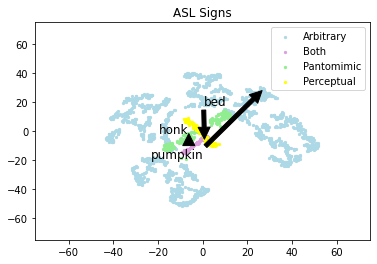

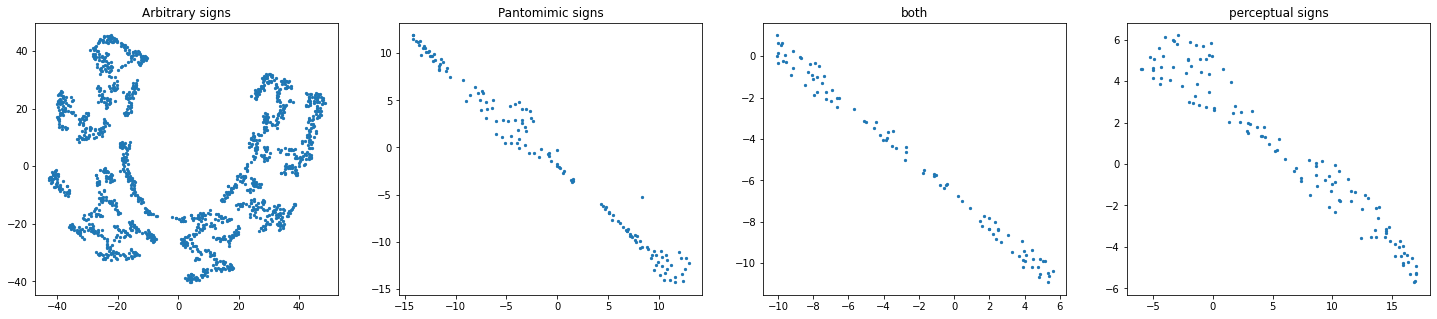

In [ ]:
plot_TSNE(np.array(X),y,np.array([0,1,2,3])); 

### Plotting certain signs in space

In [ ]:
def plot_sign(sign_IDs,X,names): # X is a dataframe
    pca_X= sklearn.decomposition.PCA(n_components=40, random_state=state).fit_transform(X) # reduce the features of X to n features 
    tsne_data= sklearn.manifold.TSNE(n_components=2).fit_transform(pca_X)
    plt.scatter(tsne_data[:,0],tsne_data[:,1])
    for id in range(len(sign_IDs)):
      plt.scatter(tsne_data[sign_IDs[id],0],tsne_data[sign_IDs[id],1],marker='o',c='red')
      plt.annotate(names[id],(tsne_data[sign_IDs[id],0],tsne_data[sign_IDs[id],1]),fontsize=12,
                arrowprops=dict(facecolor='black'))
      plt.xlim(-75,75)
      plt.ylim(-75,75)

    plt.title("ASL Signs in Space")


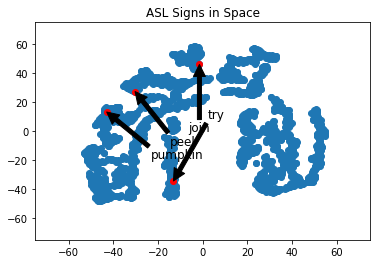

In [ ]:
plot_sign(np.array([2,3,4,5]),np.array(X),np.array(["pumpkin","peel","join","try"]))

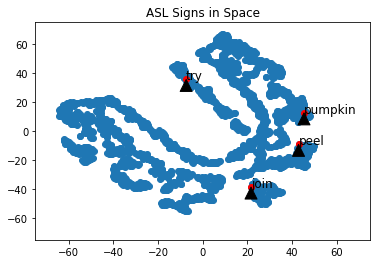

In [ ]:
plot_sign(np.array([2,3,4,5]),np.array(X),np.array(["pumpkin","peel","join","try"]))

### Normalizing and splitting the data 

In [ ]:
NA_entries_trn=np.array(np.where(y_train==4)).reshape(-1)  # Dropping NA iconicity type 
NA_entries_tst=np.array(np.where(y_test==4)).reshape(-1)



In [ ]:
global X_trn, X_tst, y_trn, y_tst
X_trn=X_train.drop(NA_entries_trn)
X_tst=X_test.drop(NA_entries_tst)

y_trn=np.delete(y_train,np.where(y_train==4))  # removing NA fields 
y_tst=np.delete(y_test,np.where(y_test==4))


In [ ]:
X_trn = sklearn.preprocessing.StandardScaler().fit_transform(X_trn) 
X_tst = sklearn.preprocessing.StandardScaler().fit_transform(X_tst) 


### Splitting the training set into validation and training sets 

In [ ]:
X_trn, X_val, y_trn, y_val= sklearn.model_selection.train_test_split(X_trn, y_trn,train_size=0.80,random_state=0)


### Autoencoder Visualization 


In [ ]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential( 
            torch.nn.Linear(146,50),
            torch.nn.Tanh(),
            torch.nn.Linear(50,2),
            
        )
        self.decoder = torch.nn.Sequential(
             
            torch.nn.Linear(2,50),
            torch.nn.Tanh(),
            torch.nn.Linear(50,146)
            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def encode(self,x):
        return  self.encoder(x)
    def decode(self,x):
        return self.decoder(x)

In [ ]:
def train(model, num_epochs=100, batch_size=1, learning_rate=0.01):    
    torch.manual_seed(0)
    criterion = torch.nn.L1Loss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5
                                 ) # <--
    train_loader = torch.utils.data.DataLoader(X_trn, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            sign = data.float()
            recon = model(sign)
            loss = criterion(recon, sign)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        if (epoch+1) % 10 == 0 :
          print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
          outputs.append((epoch, sign, recon),)
    
    return outputs

In [ ]:
model_auto = Autoencoder()

In [ ]:

outputs = train(model_auto)

Epoch:10, Loss:0.2779
Epoch:20, Loss:0.2796
Epoch:30, Loss:0.2271
Epoch:40, Loss:0.2268
Epoch:50, Loss:0.1732
Epoch:60, Loss:0.2393
Epoch:70, Loss:0.2746
Epoch:80, Loss:0.2065
Epoch:90, Loss:0.4594
Epoch:100, Loss:0.1995


In [ ]:
X_trn_compressed = model_auto.encode(torch.from_numpy(np.array(X_trn, dtype=np.float32)))
X_tst_compressed = model_auto.encode(torch.from_numpy(np.array(X_tst, dtype=np.float32)))

Text(0, 0.5, 'Hidden layer ouput 2')

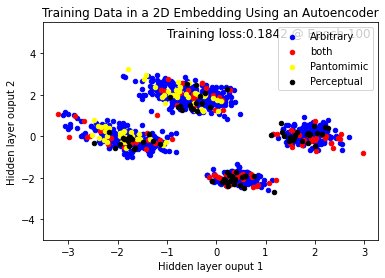

In [ ]:
compress= np.array(X_trn_compressed.detach().numpy())
arb=compress[np.where(y_trn==0)]
panto=compress[np.where(y_trn==2)]
perc=compress[np.where(y_trn==3)]
both= compress[np.where(y_trn==1)]
plt.scatter(arb[:,0],arb[:,1],c='blue',marker='o',s=20)
plt.scatter(panto[:,0],panto[:,1],c='red',marker='o',s=20)
plt.scatter(both[:,0],both[:,1],c='yellow',marker='o',s=20)
plt.scatter(perc[:,0],perc[:,1],c='black',marker='o',s=20)
plt.legend(['Arbitrary','both','Pantomimic','Perceptual'])
plt.title("Training Data in a 2D Embedding Using an Autoencoder")
plt.text(-1,4.8,"Training loss:0.1842 @ Epoch 100",fontsize=12)
plt.ylim(-5,5.5)
plt.xlabel("Hidden layer ouput 1")
plt.ylabel("Hidden layer ouput 2")

## Kernel Density Estimation 

In [ ]:
import seaborn as sns
kde = sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X_trn)
scores_density_dim=kde.score_samples(X_trn)


-3.8199127674102784 3.5833569526672364 -3.2665402412414553 3.859125566482544


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

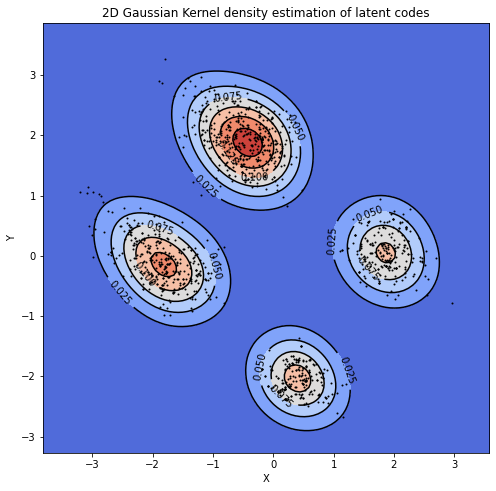

In [ ]:
x = X_trn_compressed.detach().numpy()[:, 0]
y = X_trn_compressed.detach().numpy()[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])

cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.scatter(compress[:,0],compress[:,1],c='black',marker='o',s=1)
plt.title('2D Gaussian Kernel density estimation of latent codes')
plt.savefig("kernel_estimation.png")
files.download("kernel_estimation.png") 

## Dummy Classifier Sanity Check and Setting a Benchmark

In [ ]:
dummy=sklearn.dummy.DummyClassifier( strategy='most_frequent').fit(X_trn,y_trn)
d_dummy= {'Training':[sklearn.metrics.balanced_accuracy_score(y_trn, dummy.predict(X_trn)), sklearn.metrics.precision_score(y_trn, dummy.predict(X_trn),average='micro'), sklearn.metrics.recall_score(y_trn, dummy.predict(X_trn),average='micro')] ,
          'Validation':  [sklearn.metrics.balanced_accuracy_score(y_val, dummy.predict(X_val)),sklearn.metrics.precision_score(y_val, dummy.predict(X_val),average='micro'), sklearn.metrics.recall_score(y_val, dummy.predict(X_val),average='micro')],
          'Testing': [sklearn.metrics.balanced_accuracy_score(y_tst, dummy.predict(X_tst)),sklearn.metrics.precision_score(y_tst, dummy.predict(X_tst),average='micro'), sklearn.metrics.recall_score(y_tst, dummy.predict(X_tst),average='micro')]}
dummy_df=pd.DataFrame(data=d_dummy,index=["Accuracy","Precision","Recall"],columns=["Training","Validation","Testing"])
dummy_df

,Training,Validation,Testing
Accuracy,0.2500,0.250000,0.250000
Precision,0.7897,0.828767,0.798295
Recall,0.7897,0.828767,0.798295


## Initializing variables 

In [ ]:
global validation_acc,training_acc,testing_acc,training_precision,validation_precision,testing_precision,training_recall,testing_recall,validation_recall
training_acc=[]
testing_acc=[]
validation_acc=[]
training_acc_bal=[]
testing_acc_bal=[]
validation_acc_bal=[]
training_precision=[]
testing_precision=[]
validation_precision=[]
training_recall=[]
testing_recall=[]
validation_recall=[]
indices=[]
models=[]
y_score=[]


In [ ]:
C_hyper=[]


In [ ]:
gamma_hyper=[]

# SVM Classifier

Training an OVO SVM will result in a less sensitive classifier to the problems of imbalanced datasets but is much more computationally expensive.

In [ ]:
def evaluate_model(model, averaging_method,X_trn,y_trn,X_val,y_val,X_tst,y_tst):
                                                                                            
  validation_acc.append(sklearn.metrics.balanced_accuracy_score(y_val, model.predict(X_val))) 
  training_acc.append(sklearn.metrics.balanced_accuracy_score(y_trn, model.predict(X_trn))) 
  testing_acc.append(sklearn.metrics.balanced_accuracy_score(y_tst, model.predict(X_tst)))
  training_precision.append(sklearn.metrics.precision_score(y_trn, model.predict(X_trn),average=averaging_method,zero_division="warn")) # weighted averaging to take into account class imbalance
  testing_precision.append(sklearn.metrics.precision_score(y_tst, model.predict(X_tst),average=averaging_method,zero_division="warn"))
  validation_precision.append(sklearn.metrics.precision_score(y_val, model.predict(X_val),average=averaging_method,zero_division="warn"))
  training_recall.append(sklearn.metrics.recall_score(y_trn, model.predict(X_trn),average=averaging_method,zero_division="warn"))
  testing_recall.append(sklearn.metrics.recall_score(y_tst, model.predict(X_tst),average=averaging_method,zero_division="warn"))
  validation_recall.append(sklearn.metrics.recall_score(y_val, model.predict(X_val),average=averaging_method,zero_division="warn"))

  

## OVR Balanced

In [ ]:
kernels = ['rbf','poly','linear']                                               # Specifying the kernels that we will be working with for the SVM 
averaging_method='weighted'
for m in range(len(kernels)):
    param_distributions=dict(C=loguniform(1e-2, 1e1),gamma=stats.reciprocal(0.001, 10))
    base_svm= sklearn.svm.SVC(kernel=kernels[m],class_weight="balanced", probability=True, random_state=0,decision_function_shape='ovr')
    RandomSearchCV=sklearn.model_selection.RandomizedSearchCV(base_svm, param_distributions,cv=5,n_iter=10,verbose=1,random_state=0).fit(X_val,y_val)
    base_svm= sklearn.svm.SVC(kernel=kernels[m],class_weight="balanced",C=RandomSearchCV.best_params_["C"],gamma=RandomSearchCV.best_params_["gamma"], probability=True, random_state=0,decision_function_shape='ovr').fit(X_trn,y_trn)
    
    C_hyper.append(RandomSearchCV.best_params_["C"])
    gamma_hyper.append(RandomSearchCV.best_params_["gamma"])
    models.append(base_svm)
  
    validation_acc_bal.append(sklearn.metrics.balanced_accuracy_score(y_val, models[m].predict(X_val))) 
    training_acc_bal.append(sklearn.metrics.balanced_accuracy_score(y_trn, models[m].predict(X_trn))) 
    testing_acc_bal.append(sklearn.metrics.balanced_accuracy_score(y_tst, models[m].predict(X_tst)))
    training_acc.append(models[m].score(X_trn,y_trn))
    validation_acc.append(models[m].score(X_val,y_val))
    testing_acc.append(models[m].score(X_tst,y_tst))
    
    training_precision.append(sklearn.metrics.precision_score(y_trn, models[m].predict(X_trn),average=averaging_method,zero_division="warn")) # weighted averaging to take into account class imbalance
    testing_precision.append(sklearn.metrics.precision_score(y_tst, models[m].predict(X_tst),average=averaging_method,zero_division="warn"))
    validation_precision.append(sklearn.metrics.precision_score(y_val, models[m].predict(X_val),average=averaging_method,zero_division="warn"))
    training_recall.append(sklearn.metrics.recall_score(y_trn, models[m].predict(X_trn),average=averaging_method,zero_division="warn"))
    testing_recall.append(sklearn.metrics.recall_score(y_tst, models[m].predict(X_tst),average=averaging_method,zero_division="warn"))
    validation_recall.append(sklearn.metrics.recall_score(y_val, models[m].predict(X_val),average=averaging_method,zero_division="warn"))

    indices.append("SVM OVR balanced weights " + kernels[m])
  


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.4s finished


## OVR Balanced (For ROC Binarized)

In [ ]:
kernels = ['rbf','poly','linear']                                               # Specifying the kernels that we will be working with for the SVM 
y_trn_binary= sklearn.preprocessing.label_binarize(y_trn,classes=[0,1,2,3])     # Changing the targets as binary values to make use of multiclass OVO and OVR
y_tst_binary= sklearn.preprocessing.label_binarize(y_tst,classes=[0,1,2,3])
y_val_binary= sklearn.preprocessing.label_binarize(y_val,classes=[0,1,2,3])
#param_distributions= dict(C=stats.reciprocal(0.01,1))
# The “balanced” mode uses the values of y to automatically adjust weights 
# inversely proportional to class frequencies in the input data 
# as n_samples / (n_classes * np.bincount(y)).
for m in range(len(kernels)):
    param_distributions=dict(C=loguniform(1e-2, 1e1),gamma=stats.reciprocal(0.001, 10))
    base_svm= sklearn.svm.SVC(kernel=kernels[m],class_weight="balanced", probability=True, random_state=0)
    RandomSearchCV=sklearn.model_selection.RandomizedSearchCV(base_svm, param_distributions,cv=5,n_iter=10,verbose=1,random_state=0).fit(X_val,y_val)
    classifier = OneVsRestClassifier(sklearn.svm.SVC(kernel=kernels[m],class_weight="balanced",C=RandomSearchCV.best_params_["C"], gamma=RandomSearchCV.best_params_["gamma"], probability=True, random_state=0).fit(X_trn,y_trn) )
    C_hyper.append(RandomSearchCV.best_params_["C"])
    gamma_hyper.append(RandomSearchCV.best_params_["gamma"])
    y_score.append(classifier.fit(X_trn, y_trn_binary).decision_function(X_tst))
    models.append(classifier.fit(X_trn,y_trn_binary))
  
                                                                                              
  


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.4s finished


## Visualizing Error Confusion Matrices (Before Hyperparameter Search)

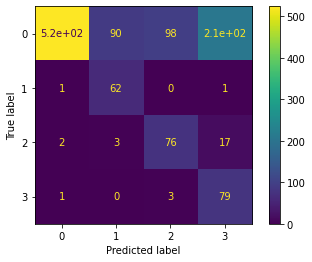

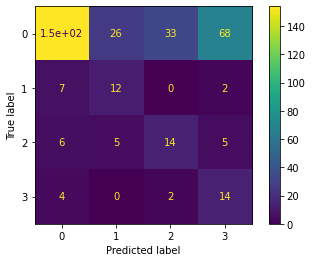

In [ ]:
classifr=sklearn.svm.SVC(kernel='rbf',gamma='scale',random_state=0,decision_function_shape='ovr',class_weight="balanced").fit(X_trn,y_trn)
sklearn.metrics.plot_confusion_matrix(classifr, X_trn, y_trn)
sklearn.metrics.plot_confusion_matrix(classifr, X_tst, y_tst)


## Plot ROC

In [ ]:
def plot_roc(y_binary,y_score):
  sign_type=['Arbitrary','Both','Pantomimic','Perceptual']
  colors=['orange','red','darkblue','black']
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(0,4):
      fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], np.array(y_score)[0:352, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_binary.ravel(), np.array(y_score)[:,:].ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(0,4)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(0,4):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= 4

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(10,5))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue','magenta'])
  for i, color in zip(range(0,4), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(sign_type[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for OVR SVM Classifier with Balanced Class Weights')
  plt.legend(loc="lower right")
  plt.show();

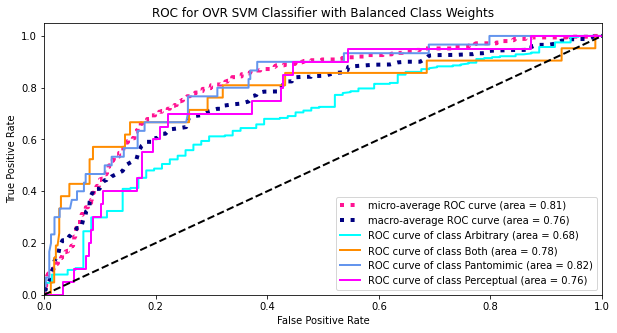

In [ ]:


classifier = OneVsRestClassifier(sklearn.svm.SVC(kernel='rbf',class_weight="balanced", probability=True, random_state=0,gamma='auto') ).fit(X_trn,y_trn)



plot_roc(y_tst_binary,classifier.fit(X_trn, y_trn_binary).decision_function(X_tst))


## Plot PR Curve

In [ ]:
def plot_pr_curve(y_binary,y_score):
  # For each class
  sign_type=['Arbitrary','Both','Pantomimic','Perceptual']
  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in range(0,4):
      precision[i], recall[i], _ = precision_recall_curve(y_binary[:, i],
                                                          np.array(y_score)[:, i])
      average_precision[i] = average_precision_score(y_binary[:, i], np.array(y_score)[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(y_binary.ravel(),
      np.array(y_score)[:,:].ravel())
  average_precision["micro"] = average_precision_score(y_binary, np.array(y_score)[:,:],
                                                      average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))
  plt.step(recall['micro'], precision['micro'], where='post')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title(
      'Average precision score, micro-averaged over all classes: AUPR={0:0.2f}'
      .format(average_precision["micro"]))
  
  colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

  plt.figure(figsize=(10, 5))
  f_scores = np.linspace(0.2, 0.8, num=4)
  lines = []
  labels = []
  
  l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
  lines.append(l)
  labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision["micro"]))

  for i, color in zip(range(0,4), colors):
      l, = plt.plot(recall[i], precision[i], color=color, lw=2)
      lines.append(l)
      labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                    ''.format(sign_type[i], average_precision[i]))

  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curves')
  plt.legend(lines, labels, loc=(0, -.65), prop=dict(size=14))


  plt.show()

Average precision score, micro-averaged over all classes: 0.55


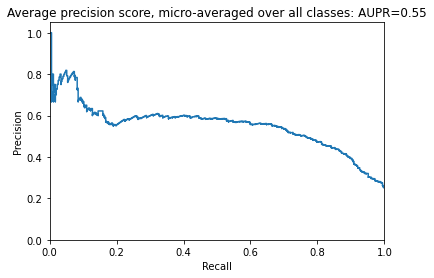

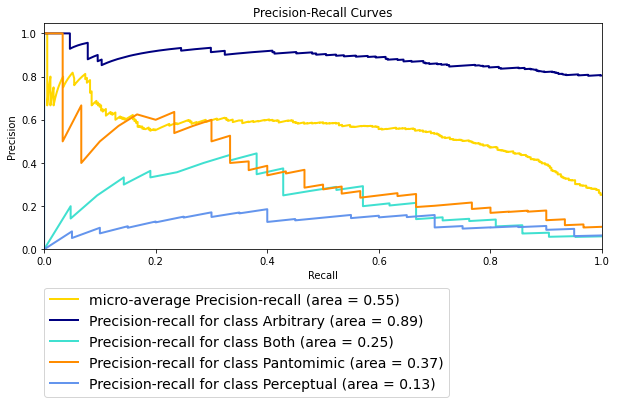

In [ ]:
#param_distributions=dict(C=loguniform(1e0, 1e1),gamma=stats.reciprocal(0.01, 10))
#base_svm= sklearn.svm.SVC(kernel='rbf', probability=True, random_state=0)
#RandomSearchCV=sklearn.model_selection.RandomizedSearchCV(base_svm, param_distributions,cv=3,n_iter=10,verbose=1,random_state=0).fit(X_trn,y_trn)
classifier = OneVsRestClassifier(sklearn.svm.SVC(kernel='rbf', gamma='auto', probability=True,class_weight='balanced', random_state=0) )

plot_pr_curve(y_tst_binary,classifier.fit(X_trn, y_trn_binary).decision_function(X_tst))

## Visualizing feature weight for SVM Linear Kernel 

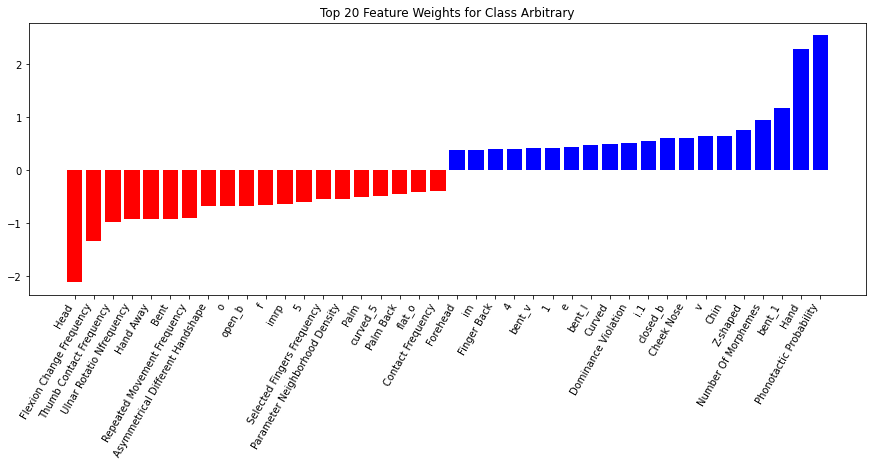

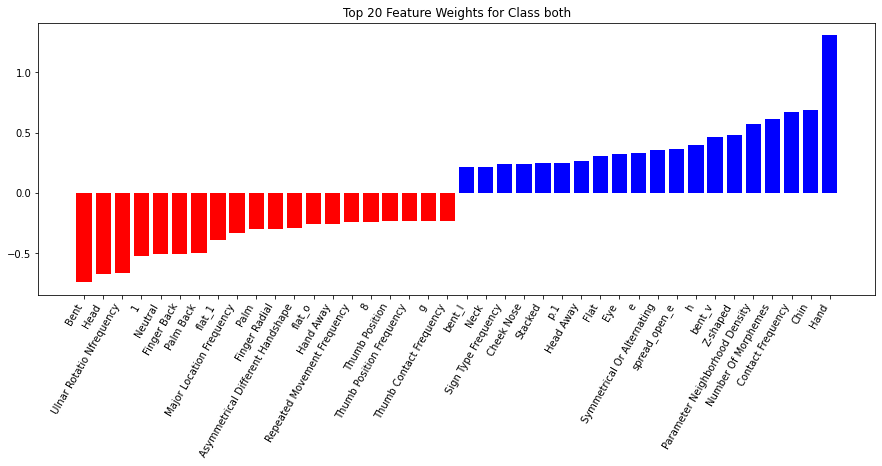

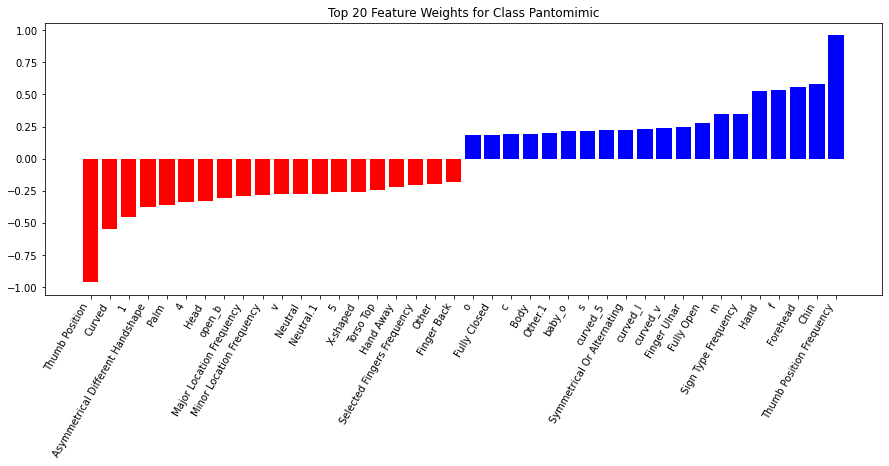

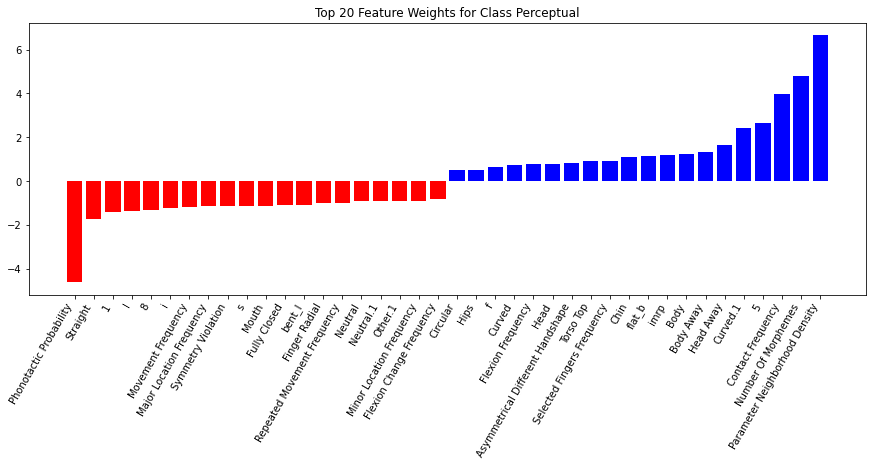

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
 sign_type=['Arbitrary','both','Pantomimic','Perceptual']
 for cc in range(0,4):
  coef = classifier.coef_[cc]
  top_positive_coefficients = np.argsort(coef)[-top_features:]
  top_negative_coefficients = np.argsort(coef)[:top_features]
  top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
  # create plot
  plt.figure(figsize=(15, 5))
  colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
  plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
  feature_names = np.array(feature_names)
  plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
  
  plt.title("Top 20 Feature Weights for Class "+sign_type[cc] )
  plt.show()


  
plot_coefficients(models[2], X_train.columns)

## OVO Balanced

In [ ]:


for m in range(len(kernels)):
  
  param_distributions=dict(C=loguniform(1e-2, 1e1),gamma=stats.reciprocal(0.001, 10))
  RandomSearchCV=sklearn.model_selection.RandomizedSearchCV(sklearn.svm.SVC(kernel=kernels[m],class_weight="balanced", decision_function_shape='ovo',random_state=0).fit(X_trn,y_trn), param_distributions,cv=3,n_iter=10,verbose=1,random_state=0).fit(X_val,y_val)
  model= sklearn.svm.SVC(kernel=kernels[m],class_weight="balanced", decision_function_shape='ovo',random_state=0,C=RandomSearchCV.best_params_["C"],gamma=RandomSearchCV.best_params_["gamma"]).fit(X_trn,y_trn)
  C_hyper.append(RandomSearchCV.best_params_["C"])
  gamma_hyper.append(RandomSearchCV.best_params_["gamma"])
  models.append(model)

  validation_acc_bal.append(sklearn.metrics.balanced_accuracy_score(y_val, models[m+3].predict(X_val))) 
  training_acc_bal.append(sklearn.metrics.balanced_accuracy_score(y_trn, models[m+3].predict(X_trn))) 
  testing_acc_bal.append(sklearn.metrics.balanced_accuracy_score(y_tst, models[m+3].predict(X_tst)))
  validation_acc.append(models[m+3].score(X_val,y_val)) 
  training_acc.append(models[m+3].score(X_trn,y_trn)) 
  testing_acc.append(models[m+3].score(X_tst,y_tst))

  training_precision.append(sklearn.metrics.precision_score(y_trn, models[m+3].predict(X_trn),average=averaging_method,zero_division="warn")) # weighted averaging to take into account class imbalance
  testing_precision.append(sklearn.metrics.precision_score(y_tst, models[m+3].predict(X_tst),average=averaging_method,zero_division="warn"))
  validation_precision.append(sklearn.metrics.precision_score(y_val, models[m+3].predict(X_val),average=averaging_method,zero_division="warn"))
  training_recall.append(sklearn.metrics.recall_score(y_trn, models[m+3].predict(X_trn),average=averaging_method,zero_division="warn"))
  testing_recall.append(sklearn.metrics.recall_score(y_tst, models[m+3].predict(X_tst),average=averaging_method,zero_division="warn"))
  validation_recall.append(sklearn.metrics.recall_score(y_val, models[m+3].predict(X_val),average=averaging_method,zero_division="warn"))
  indices.append("SVM OVO balanced weights " + kernels[m])
  

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished


In [ ]:
sklearn.metrics.multilabel_confusion_matrix(y_tst, models[4].predict(X_tst))
print(sklearn.metrics.balanced_accuracy_score(y_trn, models[5].predict(X_trn)))

0.8048839963892839


## OVO unbalanced

In [ ]:

for m in range(len(kernels)):
  
  param_distributions=dict(C=loguniform(1e-2, 1e1),gamma=stats.reciprocal(0.001, 10))
  RandomSearchCV=sklearn.model_selection.RandomizedSearchCV(sklearn.svm.SVC(kernel=kernels[m],random_state=0, decision_function_shape='ovo'), param_distributions,cv=3,n_iter=10,verbose=1,random_state=0).fit(X_val,y_val)
  C_hyper.append(RandomSearchCV.best_params_["C"])
  gamma_hyper.append(RandomSearchCV.best_params_["gamma"])
  models.append( sklearn.svm.SVC(kernel=kernels[m],gamma=RandomSearchCV.best_params_["gamma"],decision_function_shape='ovo',C=RandomSearchCV.best_params_["C"],random_state=0).fit(X_trn, y_trn))                            # automatically handles multiclass using the OVO approach
                         # automatically handles multiclass using the OVO approach
  #validation_acc.append(models[m+6].score(X_val, y_val)) 
  
 
  validation_acc_bal.append(sklearn.metrics.balanced_accuracy_score(y_val, models[m+6].predict(X_val))) 
  training_acc_bal.append(sklearn.metrics.balanced_accuracy_score(y_trn, models[m+6].predict(X_trn))) 
  testing_acc_bal.append(sklearn.metrics.balanced_accuracy_score(y_tst, models[m+6].predict(X_tst)))
  validation_acc.append(models[m+6].score(X_val,y_val)) 
  training_acc.append(models[m+6].score(X_trn,y_trn)) 
  testing_acc.append(models[m+6].score(X_tst,y_tst))
  training_precision.append(sklearn.metrics.precision_score(y_trn, models[m+6].predict(X_trn),average=averaging_method))
  validation_precision.append(sklearn.metrics.precision_score(y_val, models[m+6].predict(X_val),average=averaging_method))
  testing_precision.append(sklearn.metrics.precision_score(y_tst, models[m+6].predict(X_tst),average=averaging_method))
  training_recall.append(sklearn.metrics.recall_score(y_trn, models[m+6].predict(X_trn),average=averaging_method,zero_division="warn"))
  testing_recall.append(sklearn.metrics.recall_score(y_tst, models[m+6].predict(X_tst),average=averaging_method,zero_division="warn"))
  validation_recall.append(sklearn.metrics.recall_score(y_val, models[m+6].predict(X_val),average=averaging_method,zero_division="warn"))
  
  indices.append("SVM OVO unbalanced "+ kernels[m])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

## OVR unbalanced

In [ ]:

for m in range(len(kernels)):
  
  param_distributions=dict(C=loguniform(1e-2, 1e1),gamma=stats.reciprocal(0.001, 10))
  RandomSearchCV=sklearn.model_selection.RandomizedSearchCV(sklearn.svm.SVC(kernel=kernels[m], decision_function_shape='ovr',random_state=0), param_distributions,cv=3,n_iter=10,verbose=1,random_state=0).fit(X_val,y_val)
  C_hyper.append(RandomSearchCV.best_params_["C"])
  gamma_hyper.append(RandomSearchCV.best_params_["gamma"])
  models.append(sklearn.svm.SVC(kernel=kernels[m],gamma=RandomSearchCV.best_params_["gamma"],decision_function_shape='ovr',C=RandomSearchCV.best_params_["C"],random_state=0).fit(X_trn, y_trn) )                           # automatically handles multiclass using the OVO approach
  
  
  validation_acc_bal.append(sklearn.metrics.balanced_accuracy_score(y_val, models[m+9].predict(X_val))) 
  training_acc_bal.append(sklearn.metrics.balanced_accuracy_score(y_trn, models[m+9].predict(X_trn))) 
  testing_acc_bal.append(sklearn.metrics.balanced_accuracy_score(y_tst, models[m+9].predict(X_tst)))
  validation_acc.append(models[m+9].score(X_val,y_val)) 
  training_acc.append(models[m+9].score(X_trn,y_trn)) 
  testing_acc.append(models[m+9].score(X_tst,y_tst))
  training_precision.append(sklearn.metrics.precision_score(y_trn, models[m+9].predict(X_trn),average=averaging_method))
  testing_precision.append(sklearn.metrics.precision_score(y_tst, models[m+9].predict(X_tst),average=averaging_method))
  validation_precision.append(sklearn.metrics.precision_score(y_val, models[m+9].predict(X_val),average=averaging_method))
  training_recall.append(sklearn.metrics.recall_score(y_trn, models[m+9].predict(X_trn),average=averaging_method,zero_division="warn"))
  testing_recall.append(sklearn.metrics.recall_score(y_tst, models[m+9].predict(X_tst),average=averaging_method,zero_division="warn"))
  validation_recall.append(sklearn.metrics.recall_score(y_val, models[m+9].predict(X_val),average=averaging_method,zero_division="warn"))
  
  indices.append("SVM OVR unbalanced "+ kernels[m])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

## Values of "C" and "gamma" for SVM after Hyperparameter Search

After running the above cells without C, I ran the cell below to get C and then I re-ran the above cells with the obtained values for C.

In [ ]:
hyper_df = pd.DataFrame(data={'C':C_hyper,'gamma':gamma_hyper}, index = indices, columns = ["C","gamma"])
hyper_df

,C,gamma
SVM OVR balanced weights rbf,0.443038,0.725701
SVM OVR balanced weights poly,2.372330,0.130491
SVM OVR balanced weights linear,7.780156,0.034180
SVM OVO balanced weights rbf,0.443038,0.725701
SVM OVO balanced weights poly,0.643117,0.151193
SVM OVO balanced weights linear,7.780156,0.034180
SVM OVO unbalanced rbf,2.372330,0.130491
SVM OVO unbalanced poly,0.016335,0.002231
SVM OVO unbalanced linear,0.011499,2.140323
SVM OVR unbalanced rbf,2.372330,0.130491


# Scores after Hyperparameter Search 

In [ ]:
d = {'Training Balanced Accuracy':training_acc_bal,'Validation Balanced Accuracy':validation_acc_bal,'Testing Balanced Accuracy':testing_acc_bal,'Training Accuracy':training_acc,'Validation Accuracy':validation_acc,'Testing Accuracy': testing_acc,'Training Precision':training_precision,
     'Validation Precision':validation_precision,'Testing Precision': testing_precision,'Training Recall':training_recall,'Validation Recall':validation_recall,
     'Testing Recall':testing_recall}
scores_hyper_df = pd.DataFrame(data=d, index = indices, columns = ["Training Balanced Accuracy","Validation Balanced Accuracy","Testing Balanced Accuracy","Training Accuracy","Validation Accuracy","Testing Accuracy","Training Precision","Validation Precision","Testing Precision","Training Recall","Validation Recall","Testing Recall"])
scores_hyper_df       # do not re-run to compare before and after hyperparameter search 

,Training Balanced Accuracy,Validation Balanced Accuracy,Testing Balanced Accuracy,Training Accuracy,Validation Accuracy,Testing Accuracy,Training Precision,Validation Precision,Testing Precision,Training Recall,Validation Recall,Testing Recall
SVM OVR balanced weights rbf,0.979032,0.325596,0.318190,0.955365,0.818493,0.789773,0.964767,0.745285,0.737198,0.955365,0.818493,0.789773
SVM OVR balanced weights poly,0.981206,0.451872,0.406111,0.962232,0.729452,0.713068,0.969443,0.769023,0.722259,0.962232,0.729452,0.713068
SVM OVR balanced weights linear,0.804884,0.396087,0.420645,0.647210,0.520548,0.511364,0.847072,0.735052,0.727474,0.647210,0.520548,0.511364
SVM OVO balanced weights rbf,0.979032,0.325596,0.318190,0.955365,0.818493,0.789773,0.964767,0.745285,0.737198,0.955365,0.818493,0.789773
SVM OVO balanced weights poly,0.981206,0.452905,0.395999,0.962232,0.732877,0.704545,0.969443,0.770046,0.715915,0.962232,0.732877,0.704545
SVM OVO balanced weights linear,0.804884,0.396087,0.420645,0.647210,0.520548,0.511364,0.847072,0.735052,0.727474,0.647210,0.520548,0.511364
SVM OVO unbalanced rbf,0.897452,0.273213,0.320577,0.965665,0.780822,0.784091,0.965505,0.705576,0.733352,0.965665,0.780822,0.784091
SVM OVO unbalanced poly,0.250000,0.250000,0.250000,0.789700,0.828767,0.798295,0.623625,0.686855,0.637276,0.789700,0.828767,0.798295
SVM OVO unbalanced linear,0.262643,0.246901,0.249110,0.792275,0.818493,0.795455,0.746377,0.685382,0.636817,0.792275,0.818493,0.795455
SVM OVR unbalanced rbf,0.897452,0.273213,0.320577,0.965665,0.780822,0.784091,0.965505,0.705576,0.733352,0.965665,0.780822,0.784091


## Bagging SVM Classifier with hyperparameter search on the number of estimators

In [ ]:

clf= sklearn.svm.SVC(kernel='rbf',random_state=0,class_weight="balanced",decision_function_shape='ovr',C=0.443038,gamma=	0.725701)  
bagged_SVM = sklearn.ensemble.BaggingClassifier(base_estimator=clf,random_state=0)
param_bagging_hyper=dict(n_estimators=np.arange(1,100,1))
RandomSearchCV=sklearn.model_selection.GridSearchCV(bagged_SVM, param_bagging_hyper,cv=3,verbose=1).fit(X_val,y_val)
bagged_SVM = sklearn.ensemble.BaggingClassifier(base_estimator=clf,random_state=0,n_estimators=RandomSearchCV.best_params_["n_estimators"]).fit(X_trn,y_trn)


Fitting 3 folds for each of 99 candidates, totalling 297 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 297 out of 297 | elapsed:  3.7min finished


In [ ]:
d_bagged= {'Training':[bagged_SVM.score(X_trn,y_trn), sklearn.metrics.precision_score(y_trn, bagged_SVM.predict(X_trn),average='weighted'), sklearn.metrics.recall_score(y_trn, bagged_SVM.predict(X_trn),average='weighted'),sklearn.metrics.balanced_accuracy_score(y_trn,bagged_SVM.predict(X_trn))] ,
          'Validation':  [bagged_SVM.score(X_val,y_val),sklearn.metrics.precision_score(y_val, bagged_SVM.predict(X_val),average='weighted'), sklearn.metrics.recall_score(y_val, bagged_SVM.predict(X_val),average='weighted'),sklearn.metrics.balanced_accuracy_score(y_val,bagged_SVM.predict(X_val))],
          'Testing': [bagged_SVM.score(X_tst,y_tst),sklearn.metrics.precision_score(y_tst, bagged_SVM.predict(X_tst),average='weighted'), sklearn.metrics.recall_score(y_tst, bagged_SVM.predict(X_tst),average='weighted'),sklearn.metrics.balanced_accuracy_score(y_tst,bagged_SVM.predict(X_tst))]}
bagged_df=pd.DataFrame(data=d_bagged,index=["Accuracy","Precision","Recall","Balanced Accuracy"],columns=["Training","Validation","Testing"])
bagged_df

,Training,Validation,Testing
Accuracy,0.938197,0.811644,0.798295
Precision,0.938587,0.731896,0.749941
Recall,0.938197,0.811644,0.798295
Balanced Accuracy,0.871965,0.282511,0.320859


# SVM with SMOTE 

/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (2000) in class 1 will be larger than the number of samples in the majority class (class #0 -> 920)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 920)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (2000) in class 3 will be larger than the number of samples in the majority class (class #0 -> 920)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (2000) in class 1 will be larger than the number of samples in the majority class (class #0 -> 920)
  n_samples

Class=0, n=920 (13.295%)
Class=1, n=2000 (28.902%)
Class=2, n=2000 (28.902%)
Class=3, n=2000 (28.902%)


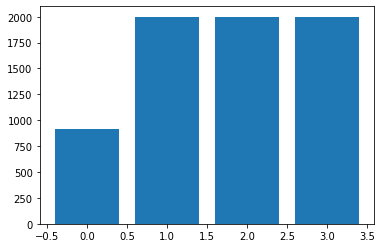

In [ ]:
from collections import Counter
from imblearn import under_sampling
oversample = SMOTE( sampling_strategy={1:2000,2:2000,3:2000},random_state=0,k_neighbors=10).fit(X_trn,y_trn)
#undersample = under_sampling.RandomUnderSampler(sampling_strategy={0:200},random_state=0)
#X_trn_under, y_trn_under = undersample.fit_resample(X_trn,y_trn)
#X_val_under, y_val_under = undersample.fit_resample(X_val,y_val)
#X_tst_under, y_tst_under = undersample.fit_resample(X_tst,y_tst)
X_trn_smote, y_trn_smote = oversample.fit_resample(X_trn, y_trn)
X_tst_smote, y_tst_smote = oversample.fit_resample(X_tst, y_tst) # 
X_val_smote, y_val_smote = oversample.fit_resample(X_val, y_val)
# summarize distribution
counter = Counter(y_trn_smote)
for k,v in counter.items():
	per = v / len(y_trn_smote) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:

#classifier_smotee= sklearn.svm.SVC(kernel='rbf',random_state=0,decision_function_shape='ovr').fit(X_trn_smote,y_trn_smote)
#random_search=sklearn.model_selection.RandomizedSearchCV(classifier_smotee,param_distributions={"C":loguniform(1e-2, 1e1),"gamma":loguniform(1e-1, 1e1)},cv=3,random_state=0,verbose=True).fit(X_val_smote,y_val_smote)
classifier_smote= sklearn.svm.SVC(kernel='rbf',random_state=0,decision_function_shape='ovr',C=0.4,gamma=0.5846326121643413,class_weight="balanced").fit(X_trn_smote,y_trn_smote)
d_smote= {'Training':[classifier_smote.score(X_trn,y_trn), sklearn.metrics.precision_score(y_trn, classifier_smote.predict(X_trn),average='weighted'), sklearn.metrics.recall_score(y_trn, classifier_smote.predict(X_trn),average='weighted'),sklearn.metrics.balanced_accuracy_score(y_trn_smote,classifier_smote.predict(X_trn_smote))] ,
          'Validation':  [classifier_smote.score(X_val,y_val),sklearn.metrics.precision_score(y_val, classifier_smote.predict(X_val),average='weighted'), sklearn.metrics.recall_score(y_val, classifier_smote.predict(X_val),average='weighted'),sklearn.metrics.balanced_accuracy_score(y_val,classifier_smote.predict(X_val))],
          'Testing': [classifier_smote.score(X_tst,y_tst),sklearn.metrics.precision_score(y_tst, classifier_smote.predict(X_tst),average='weighted'), sklearn.metrics.recall_score(y_tst, classifier_smote.predict(X_tst),average='weighted'),sklearn.metrics.balanced_accuracy_score(y_tst,classifier_smote.predict(X_tst))]}
smote_df=pd.DataFrame(data=d_smote,index=["Accuracy","Precision","Recall","Balanced Accuracy"],columns=["Training","Validation","Testing"])
smote_df

,Training,Validation,Testing
Accuracy,0.963090,0.818493,0.786932
Precision,0.966532,0.745285,0.739069
Recall,0.963090,0.818493,0.786932
Balanced Accuracy,0.972158,0.325596,0.328910


#Draft Models (not included in report)



# Random Forest

In [ ]:
model_forest = sklearn.ensemble.RandomForestClassifier(random_state=0,class_weight="balanced").fit(X_trn, y_trn)
GridSearch=sklearn.model_selection.GridSearchCV(model_forest,param_grid={"n_estimators":[100, 150, 200, 250],"max_depth":[1,5,10,20,50,100]}).fit(X_trn,y_trn)
model_forest = sklearn.ensemble.RandomForestClassifier(random_state=0,class_weight="balanced",n_estimators=GridSearch.best_params_["n_estimators"],max_depth=GridSearch.best_params_["max_depth"]).fit(X_trn, y_trn)
#indices.append("Random Forest")
d_forest= {'Training':[model_forest.score(X_trn,y_trn), sklearn.metrics.precision_score(y_trn, model_forest.predict(X_trn),average='weighted'), sklearn.metrics.recall_score(y_trn, model_forest.predict(X_trn),average='weighted'),sklearn.metrics.f1_score(y_trn, model_forest.predict(X_trn),  average='weighted', zero_division='warn')] ,
          'Validation':  [model_forest.score(X_val,y_val),sklearn.metrics.precision_score(y_val, model_forest.predict(X_val),average='weighted'), sklearn.metrics.recall_score(y_val, model_forest.predict(X_val),average='weighted'),sklearn.metrics.f1_score(y_val, model_forest.predict(X_val),  average='weighted', zero_division='warn')],
          'Testing': [model_forest.score(X_tst,y_tst),sklearn.metrics.precision_score(y_tst, model_forest.predict(X_tst),average='weighted'), sklearn.metrics.recall_score(y_tst, model_forest.predict(X_tst),average='weighted'),sklearn.metrics.f1_score(y_tst, model_forest.predict(X_tst),  average='weighted', zero_division='warn')]}
forest_df=pd.DataFrame(data=d_forest,index=["Accuracy","Precision","Recall","f1 score"],columns=["Training","Validation","Testing"])
forest_df


,Training,Validation,Testing
Accuracy,0.970696,0.789041,0.778409
Precision,0.974294,0.741504,0.724636
Recall,0.970696,0.789041,0.778409
f1 score,0.971582,0.761110,0.741027


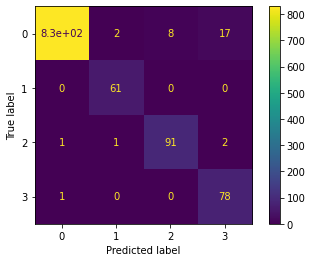

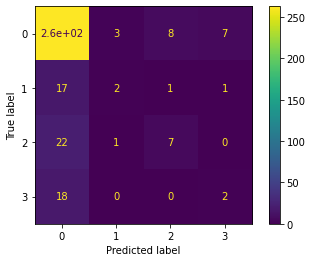

In [ ]:
sklearn.metrics.plot_confusion_matrix(model_forest, X_trn, y_trn)
sklearn.metrics.plot_confusion_matrix(model_forest, X_tst, y_tst)

# MLP Classifier (No hidden layers with sigmoid activation ~ Softmax Multinomial Regression

0.7703703395048868
0.7066047547083962
0.6642045454545454
0.8025751072961373
0.8047945205479452
0.78125


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


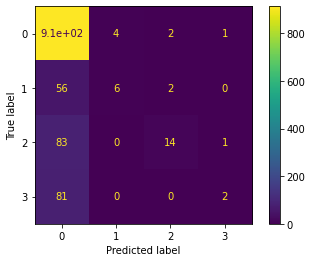

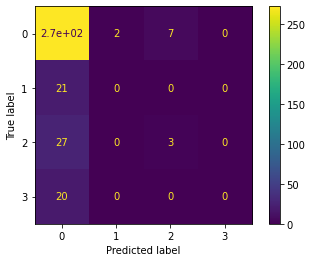

In [ ]:
alpha_dist=dict(alpha=loguniform(1e-3, 1e0))

model= sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(),activation='logistic',solver='sgd',learning_rate_init=0.01,momentum=0.9,early_stopping=True,random_state=0,batch_size=50,max_iter=100)
random_search= sklearn.model_selection.RandomizedSearchCV(model,alpha_dist,cv=3,random_state=0).fit(X_val,y_val)
model= sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(),activation='logistic',alpha=random_search.best_params_["alpha"],solver='sgd',learning_rate_init=0.01,momentum=0.9,early_stopping=True,random_state=0,batch_size=50,max_iter=100).fit(X_trn,y_trn)

print(sklearn.metrics.precision_score(y_trn, model.predict(X_trn),average='weighted'))
print(sklearn.metrics.precision_score(y_val, model.predict(X_val),average='weighted'))
print(sklearn.metrics.precision_score(y_tst, model.predict(X_tst),average='weighted'))
print(sklearn.metrics.recall_score(y_trn, model.predict(X_trn),average='weighted'))
print(sklearn.metrics.recall_score(y_val, model.predict(X_val),average='weighted'))
print(sklearn.metrics.recall_score(y_tst, model.predict(X_tst),average='weighted'))
sklearn.metrics.plot_confusion_matrix(model, X_trn, y_trn)
sklearn.metrics.plot_confusion_matrix(model, X_tst, y_tst)


0.8159539166876992
0.762063021362371
0.7319800481821971
0.5982832618025751
0.5171232876712328
0.5227272727272727


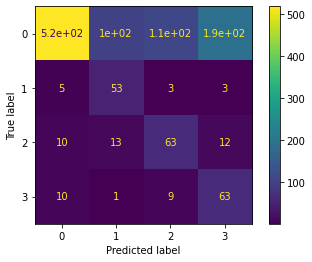

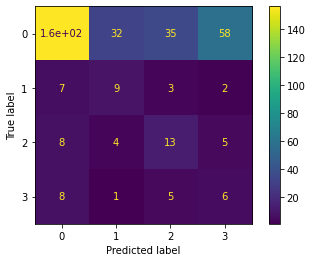

In [ ]:
C_dist=dict(C=loguniform(1e-3,1e1))
model=sklearn.linear_model.LogisticRegression(penalty='l2',class_weight="balanced", random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=500)
random_search=sklearn.model_selection.RandomizedSearchCV(model,C_dist,random_state=0,cv=5,n_iter=50).fit(X_val,y_val)
model=sklearn.linear_model.LogisticRegression(penalty='l2', C=random_search.best_params_["C"], class_weight="balanced",random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=500).fit(X_trn_smote,y_trn_smote)
print(sklearn.metrics.precision_score(y_trn, model.predict(X_trn),average='weighted'))
print(sklearn.metrics.precision_score(y_val, model.predict(X_val),average='weighted'))
print(sklearn.metrics.precision_score(y_tst, model.predict(X_tst),average='weighted'))
print(sklearn.metrics.recall_score(y_trn, model.predict(X_trn),average='weighted'))
print(sklearn.metrics.recall_score(y_val, model.predict(X_val),average='weighted'))
print(sklearn.metrics.recall_score(y_tst, model.predict(X_tst),average='weighted'))
sklearn.metrics.plot_confusion_matrix(model, X_trn, y_trn)
sklearn.metrics.plot_confusion_matrix(model, X_tst, y_tst)

In [ ]:
print(model)

LogisticRegression(C=0.001923730509654649,
                   class_weight={0: 1, 1: 10, 2: 10, 3: 10}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)


# MLP with Relu activation

In [ ]:
pca_obj= sklearn.decomposition.PCA(random_state=0)
components = np.arange(1,140)
pca_grid=sklearn.model_selection.GridSearchCV(pca_obj,param_grid={"n_components":components}).fit(X_trn,y_trn)
pca= sklearn.decomposition.PCA(n_components=pca_grid.best_params_["n_components"], random_state=0).fit(X_trn,y_trn)
X_trn_pca = pca.transform(X_trn)
X_tst_pca = pca.transform(X_tst)
X_val_pca = pca.transform(X_val)
model= sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100,50,), activation='tanh',solver='sgd',learning_rate_init=0.01,momentum=0.9,early_stopping=True,random_state=0,batch_size=100,max_iter=100).fit(X_trn_pca,y_trn)



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:788: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


In [ ]:
print(pca_grid.best_params_["n_components"])

13


0.672334082049939
0.6982548320510414
0.637275632747934
0.7857142857142857
0.8356164383561644
0.7982954545454546


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


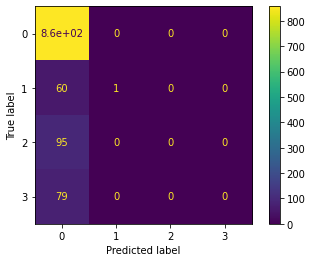

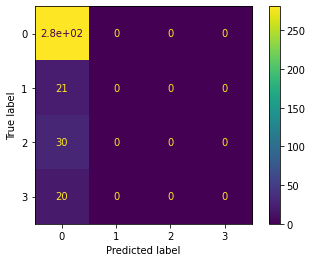

In [ ]:
print(sklearn.metrics.precision_score(y_trn, model.predict(X_trn_pca),average='weighted'))
print(sklearn.metrics.precision_score(y_val, model.predict(X_val_pca),average='weighted'))
print(sklearn.metrics.precision_score(y_tst, model.predict(X_tst_pca),average='weighted'))
print(sklearn.metrics.recall_score(y_trn, model.predict(X_trn_pca),average='weighted'))
print(sklearn.metrics.recall_score(y_val, model.predict(X_val_pca),average='weighted'))
print(sklearn.metrics.recall_score(y_tst, model.predict(X_tst_pca),average='weighted'))
sklearn.metrics.plot_confusion_matrix(model, X_trn_pca, y_trn)
sklearn.metrics.plot_confusion_matrix(model, X_tst_pca, y_tst)

# KNN 

In [ ]:
pca_grid=sklearn.model_selection.GridSearchCV(pca,param_grid={"n_components":[10,15,20,25,30,35,40]}).fit(X_trn,y_trn)
pca= sklearn.decomposition.PCA(n_components=pca_grid.best_params_["n_components"], random_state=0).fit(X_trn,y_trn)
X_trn_pca = pca.transform(X_trn)
X_tst_pca = pca.transform(X_tst)
X_val_pca = pca.transform(X_val)
knn_model=sklearn.neighbors.KNeighborsClassifier(n_neighbors=5).fit(X_trn_pca,y_trn)
GridSearch=sklearn.model_selection.GridSearchCV(knn_model,param_grid={"n_neighbors":[50,100,150,200,250,300]}).fit(X_trn_pca,y_trn)
knn_model=sklearn.neighbors.KNeighborsClassifier(n_neighbors=GridSearch.best_params_["n_neighbors"]).fit(X_trn_pca,y_trn)
d_knn= {'Training':[knn_model.score(X_trn_pca,y_trn), sklearn.metrics.precision_score(y_trn, knn_model.predict(X_trn_pca),average='macro'), sklearn.metrics.recall_score(y_trn, knn_model.predict(X_trn_pca),average='macro'),sklearn.metrics.f1_score(y_trn, knn_model.predict(X_trn_pca),  average='weighted', zero_division='warn')] ,
          'Validation':  [knn_model.score(X_val_pca,y_val),sklearn.metrics.precision_score(y_val, knn_model.predict(X_val_pca),average='macro'), sklearn.metrics.recall_score(y_val, knn_model.predict(X_val_pca),average='macro'),sklearn.metrics.f1_score(y_val, knn_model.predict(X_val_pca),  average='weighted', zero_division='warn')],
          'Testing': [knn_model.score(X_tst_pca,y_tst),sklearn.metrics.precision_score(y_tst, knn_model.predict(X_tst_pca),average='macro'), sklearn.metrics.recall_score(y_tst, knn_model.predict(X_tst_pca),average='macro'),sklearn.metrics.f1_score(y_tst, knn_model.predict(X_tst_pca),  average='weighted', zero_division='warn')]}
knn_df=pd.DataFrame(data=d_knn,index=["Accuracy","Precision","Recall","f1 score"],columns=["Training","Validation","Testing"])
knn_df

                                       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Training,Validation,Testing
Accuracy,0.784799,0.835616,0.798295
Precision,0.196200,0.208904,0.199574
Recall,0.250000,0.250000,0.250000
f1 score,0.690172,0.760785,0.708755


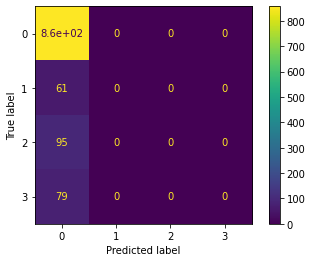

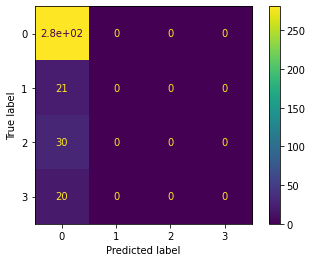

In [ ]:
sklearn.metrics.plot_confusion_matrix(knn_model, X_trn_pca, y_trn)
sklearn.metrics.plot_confusion_matrix(knn_model, X_tst_pca, y_tst)

# Adaboost with Tree Stump Classifier

0.3413718125286924
0.2897225239905848


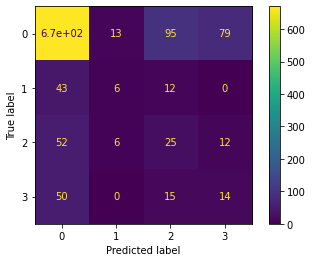

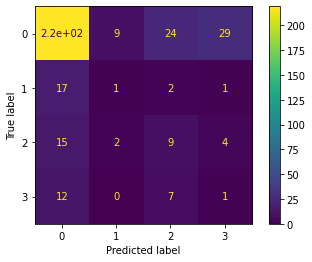

In [ ]:
model = sklearn.ensemble.AdaBoostClassifier().fit(X_trn, y_trn)

print(sklearn.metrics.precision_score(y_trn, model.predict(X_trn),average='macro'))
print(sklearn.metrics.precision_score(y_tst, model.predict(X_tst),average='macro'))
sklearn.metrics.plot_confusion_matrix(model, X_trn, y_trn)
sklearn.metrics.plot_confusion_matrix(model, X_tst, y_tst)